In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q tensorflow matplotlib scikit-learn seaborn


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# Change this path if needed
dataset_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

img_size = (224, 224)
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)


Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


# Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import os
from pathlib import Path

#  Set your existing paths
RAW_DATA_DIR = "/content/drive/MyDrive/Dataset_BUSI_with_GT"
AUG_DATA_DIR = "/content/drive/MyDrive/BUSI_augmented"

#  Augmentor setup
augmentor = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#  Augment each image 2 times
def augment_class_images(class_name, augment_count=2):
    input_path = os.path.join(RAW_DATA_DIR, class_name)
    output_path = os.path.join(AUG_DATA_DIR, class_name)
    os.makedirs(output_path, exist_ok=True)

    image_paths = list(Path(input_path).glob("*.jpg")) + list(Path(input_path).glob("*.png"))

    for img_path in image_paths:
        img = load_img(img_path)
        x = img_to_array(img).reshape((1,) + img.size[::-1] + (3,))
        base_name = Path(img_path).stem
        for i, batch in enumerate(augmentor.flow(x, batch_size=1)):
            save_img(os.path.join(output_path, f"{base_name}_aug{i}.jpg"), batch[0])
            if i + 1 >= augment_count:
                break
        print(f" {base_name} -> {augment_count} augmentations in '{class_name}'")

#  Run for each class
for cls in ["benign", "malignant", "normal"]:  # remove "normal" if not present
    if os.path.exists(os.path.join(RAW_DATA_DIR, cls)):
        augment_class_images(cls, augment_count=2)


✅ benign (1)_mask -> 2 augmentations in 'benign'
✅ benign (100) -> 2 augmentations in 'benign'
✅ benign (1) -> 2 augmentations in 'benign'
✅ benign (101) -> 2 augmentations in 'benign'
✅ benign (106) -> 2 augmentations in 'benign'
✅ benign (10) -> 2 augmentations in 'benign'
✅ benign (103)_mask -> 2 augmentations in 'benign'
✅ benign (100)_mask_1 -> 2 augmentations in 'benign'
✅ benign (10)_mask -> 2 augmentations in 'benign'
✅ benign (100)_mask -> 2 augmentations in 'benign'
✅ benign (101)_mask -> 2 augmentations in 'benign'
✅ benign (104)_mask -> 2 augmentations in 'benign'
✅ benign (104) -> 2 augmentations in 'benign'
✅ benign (105)_mask -> 2 augmentations in 'benign'
✅ benign (102) -> 2 augmentations in 'benign'
✅ benign (103) -> 2 augmentations in 'benign'
✅ benign (102)_mask -> 2 augmentations in 'benign'
✅ benign (105) -> 2 augmentations in 'benign'
✅ benign (136)_mask -> 2 augmentations in 'benign'
✅ benign (145) -> 2 augmentations in 'benign'
✅ benign (12)_mask -> 2 augmentati

In [7]:
import os

# Dataset path
dataset_path = "/content/drive/MyDrive/BUSI_augmented"
img_size = (224, 224)
batch_size = 32
num_classes = 3


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Only rescale now, no further augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% training, 20% validation
)

train_generator = data_gen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = data_gen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print(" Classes found:", class_names)


Found 3845 images belonging to 3 classes.
Found 960 images belonging to 3 classes.
 Classes found: ['benign', 'malignant', 'normal']


# ABER Optimizer

In [6]:
import random
import numpy as np

def aber_optimize(fitness_function, bounds, n_agents=5, max_iter=5):

    # Initialize agents randomly
    population = []
    for _ in range(n_agents):
        agent = [random.uniform(b[0], b[1]) for b in bounds]
        population.append(agent)

    best_solution = None
    best_score = -np.inf

    for iteration in range(max_iter):
        print(f"\n ABER Iteration {iteration + 1}/{max_iter}")
        new_population = []

        for i, agent in enumerate(population):
            # Mutate one of the parameters (exploration)
            new_agent = agent.copy()
            param_to_mutate = random.randint(0, len(bounds) - 1)
            new_agent[param_to_mutate] = random.uniform(bounds[param_to_mutate][0], bounds[param_to_mutate][1])

            # Evaluate both original and mutated
            score_old = fitness_function(agent)
            score_new = fitness_function(new_agent)

            # Keep the better one
            if score_new > score_old:
                new_population.append(new_agent)
                if score_new > best_score:
                    best_score = score_new
                    best_solution = new_agent
                print(f" Agent {i+1} improved → Acc: {score_new:.4f}")
            else:
                new_population.append(agent)
                if score_old > best_score:
                    best_score = score_old
                    best_solution = agent
                print(f" Agent {i+1} retained → Acc: {score_old:.4f}")

        population = new_population

    print("\n ABER Optimization Finished!")
    return best_solution, best_score


In [5]:
# BUSI dataset
img_size = (224, 224)
batch_size = 32
num_classes = 3
dataset_path = "/content/drive/MyDrive/BUSI_augmented"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen.flow_from_directory(
    dataset_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True, seed=42
)

val_generator = data_gen.flow_from_directory(
    dataset_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False, seed=42
)

class_names = list(train_generator.class_indices.keys())


Found 3845 images belonging to 3 classes.
Found 960 images belonging to 3 classes.


In [ ]:
def evaluate_model_with_params(params, base_model_fn, train_gen, val_gen):
    lr, dropout, dense_units = params

    base_model = base_model_fn(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(float(dropout))(x)
    x = Dense(int(dense_units), activation='relu')(x)
    x = Dropout(float(dropout))(x)
    output = Dense(train_gen.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=float(lr)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # ⚡ Reduced time
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=1,  # ⚡ One epoch only
        steps_per_epoch=min(10, len(train_gen)),
        validation_steps=min(5, len(val_gen)),
        verbose=0
    )

    return history.history['val_accuracy'][-1]


# VGG16 ABER

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("\n Running ABER Optimization for VGG16...")

bounds = [(1e-5, 1e-3), (0.2, 0.5), (64, 256)]

best_params_vgg16, best_acc_vgg16 = aber_optimize(
    lambda params: evaluate_model_with_params(params, VGG16, train_generator, val_generator),
    bounds,
    n_agents=3,
    max_iter=3
)

print(f"\n VGG16 ABER → LR: {best_params_vgg16[0]:.6f}, Dropout: {best_params_vgg16[1]:.2f}, Units: {int(best_params_vgg16[2])}, Acc: {best_acc_vgg16:.4f}")



🔍 Running ABER Optimization for VGG16...

🌀 ABER Iteration 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 improved → Acc: 1.0000

🌀 ABER Iteration 2/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 improved → Acc: 1.0000
🐝 Agent 3 retained → Acc: 1.0000

🌀 ABER Iteration 3/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 0.0125
🐝 Agent 3 improved → Acc: 1.0000

🏁 ABER Optimization Finished!

✅ VGG16 ABER → LR: 0.000408, Dropout: 0.39, Units: 238, Acc: 1.0000


# ABER for ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

print("\n Running ABER Optimization for ResNet50...")
bounds = [(1e-5, 1e-3), (0.2, 0.5), (64, 256)]


best_params_resnet50, best_acc_resnet50 = aber_optimize(
    lambda params: evaluate_model_with_params(params, ResNet50, train_generator, val_generator),
    bounds,
    n_agents=3,
    max_iter=3
)

print(f"\n ResNet50 ABER → LR: {best_params_resnet50[0]:.6f}, Dropout: {best_params_resnet50[1]:.2f}, Units: {int(best_params_resnet50[2])}, Acc: {best_acc_resnet50:.4f}")



🔍 Running ABER Optimization for ResNet50...

🌀 ABER Iteration 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 retained → Acc: 1.0000

🌀 ABER Iteration 2/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 improved → Acc: 1.0000

🌀 ABER Iteration 3/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 retained → Acc: 1.0000

🏁 ABER Optimization Finished!

✅ ResNet50 ABER → LR: 0.000305, Dropout: 0.47, Units: 123, Acc: 1.0000


# ABER for MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

print("\n🔍 Running ABER Optimization for MobileNetV2...")
bounds = [(1e-5, 1e-3), (0.2, 0.5), (64, 256)]

best_params_mobilenetv2, best_acc_mobilenetv2 = aber_optimize(
    lambda params: evaluate_model_with_params(params, MobileNetV2, train_generator, val_generator),
    bounds,
    n_agents=3,
    max_iter=3
)

print(f"\n✅ MobileNetV2 ABER → LR: {best_params_mobilenetv2[0]:.6f}, Dropout: {best_params_mobilenetv2[1]:.2f}, Units: {int(best_params_mobilenetv2[2])}, Acc: {best_acc_mobilenetv2:.4f}")



🔍 Running ABER Optimization for MobileNetV2...

🌀 ABER Iteration 1/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 improved → Acc: 1.0000
🐝 Agent 3 improved → Acc: 0.9750

🌀 ABER Iteration 2/3
🐝 Agent 1 improved → Acc: 0.9937
🐝 Agent 2 improved → Acc: 0.9812
🐝 Agent 3 retained → Acc: 0.3313

🌀 ABER Iteration 3/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 improved → Acc: 1.0000

🏁 ABER Optimization Finished!

✅ MobileNetV2 ABER → LR: 0.000640, Dropout: 0.44, Units: 124, Acc: 1.0000


# ABER for EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

print("\n🔍 Running ABER Optimization for EfficientNetB0...")
bounds = [(1e-5, 1e-3), (0.2, 0.5), (64, 256)]

best_params_effnet, best_acc_effnet = aber_optimize(
    lambda params: evaluate_model_with_params(params, EfficientNetB0, train_generator, val_generator),
    bounds,
    n_agents=3,
    max_iter=3
)

print(f"\n✅ EfficientNetB0 ABER → LR: {best_params_effnet[0]:.6f}, Dropout: {best_params_effnet[1]:.2f}, Units: {int(best_params_effnet[2])}, Acc: {best_acc_effnet:.4f}")



🔍 Running ABER Optimization for EfficientNetB0...

🌀 ABER Iteration 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 retained → Acc: 1.0000

🌀 ABER Iteration 2/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 retained → Acc: 1.0000

🌀 ABER Iteration 3/3
🐝 Agent 1 retained → Acc: 1.0000
🐝 Agent 2 retained → Acc: 1.0000
🐝 Agent 3 retained → Acc: 1.0000

🏁 ABER Optimization Finished!

✅ EfficientNetB0 ABER → LR: 0.000159, Dropout: 0.38, Units: 181, Acc: 1.0000


In [ ]:
# Dictionary of final ABER-optimized validation accuracies
aber_model_accuracies = {
    "VGG16_ABER": 1.0000,
    "ResNet50_ABER": 1.0000,
    "MobileNetV2_ABER": 1.0000,
    "EfficientNetB0_ABER": 1.0000
}

# Find the best model
best_model = max(aber_model_accuracies, key=aber_model_accuracies.get)
best_accuracy = aber_model_accuracies[best_model]

print(" Best ABER-Optimized Model:")
print(f" Model Name: {best_model}")
print(f" Validation Accuracy: {best_accuracy:.4f}")


 Best ABER-Optimized Model:
 Model Name: VGG16_ABER
 Validation Accuracy: 1.0000


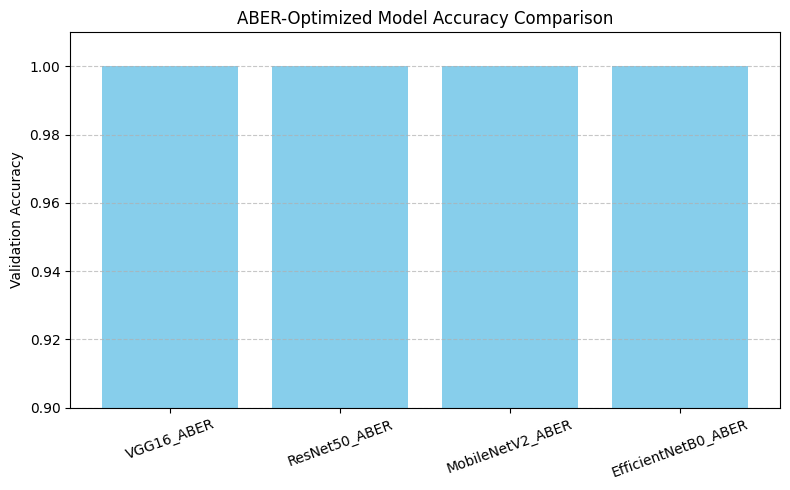

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 5))
plt.bar(aber_model_accuracies.keys(), aber_model_accuracies.values(), color='skyblue')
plt.ylim(0.9, 1.01)
plt.ylabel("Validation Accuracy")
plt.title("ABER-Optimized Model Accuracy Comparison")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Save Models

# vgg16

In [6]:
import os
from PIL import Image

def remove_corrupt_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify if image can be opened
            except (IOError, SyntaxError, Image.DecompressionBombError):
                print(f" Removing corrupt image: {file_path}")
                os.remove(file_path)
                removed += 1
    print(f" Done. Total corrupt images removed: {removed}")

# Example:
remove_corrupt_images("/content/drive/MyDrive/BUSI_augmented")


 Done. Total corrupt images removed: 0


In [7]:
import os

def list_non_images(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f" Not an image: {os.path.join(root, file)}")

list_non_images("/content/drive/MyDrive/BUSI_augmented")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - accuracy: 0.6651 - loss: 0.8501 - val_accuracy: 0.7427 - val_loss: 0.6541
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.7492 - loss: 0.6358 - val_accuracy: 0.7698 - val_loss: 0.5801
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 257ms/step - accuracy: 0.7997 - loss: 0.5298 - val_accuracy: 0.8219 - val_loss: 0.5480
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 0.8095 - loss: 0.5021 - val_accuracy: 0.8302 - val_loss: 0.5180
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.8415 - loss: 0.4432 - val_accuracy: 0.8292 - val_loss: 0.5041
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 263ms/step - accuracy: 0.8473 - loss: 0.4302 - val_accuracy: 0.8354 - val_loss: 0.5073
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step - accuracy: 0.8419 - loss: 0.4217 - val_accuracy: 0.8344 - val_loss: 0.4749
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.8470 - loss: 0

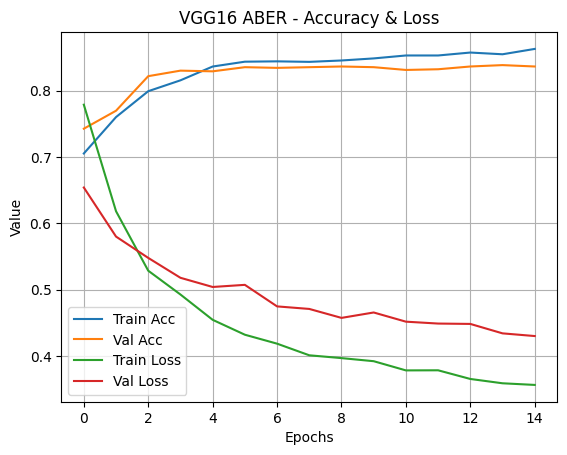

 VGG16_ABER - Train Accuracy: 0.8629
 VGG16_ABER - Val Accuracy:   0.8365
 Time Taken: 7.81 minutes


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

#  Start time
start_time = time.time()

# Build model
base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.39)(x)
x = Dense(238, activation='relu')(x)
x = Dropout(0.39)(x)
output = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base.input, outputs=output)
vgg16_model.compile(optimizer=Adam(learning_rate=0.000408), loss='categorical_crossentropy', metrics=['accuracy'])

#  Train model & save history
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

#  End time
end_time = time.time()

#  Save model
vgg16_model.save("/content/drive/MyDrive/Final_ABER_Models/VGG16_ABER_Optimized.keras")

#  Plot accuracy & loss
plt.plot(history_vgg16.history['accuracy'], label='Train Acc')
plt.plot(history_vgg16.history['val_accuracy'], label='Val Acc')
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Val Loss')
plt.title("VGG16 ABER - Accuracy & Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

#  Final accuracy
train_acc = history_vgg16.history['accuracy'][-1]
val_acc = history_vgg16.history['val_accuracy'][-1]

print(f" VGG16_ABER - Train Accuracy: {train_acc:.4f}")
print(f" VGG16_ABER - Val Accuracy:   {val_acc:.4f}")
print(f" Time Taken: {(end_time - start_time)/60:.2f} minutes")


# resnet50

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.6269 - loss: 1.0447 - val_accuracy: 0.7198 - val_loss: 0.7272
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.7199 - loss: 0.7646 - val_accuracy: 0.7260 - val_loss: 0.7273
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.7059 - loss: 0.7644 - val_accuracy: 0.7531 - val_loss: 0.7175
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - accuracy: 0.7300 - loss: 0.7114 - val_accuracy: 0.7594 - val_loss: 0.6863
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.7351 - loss: 0.6945 - val_accuracy: 0.7542 - val_loss: 0.6620
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.7412 - loss: 0.6781 - val_accuracy: 0.7646 - val_loss: 0.7111
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.7440 - loss: 0.6848 - val_accuracy: 0.7583 - val_loss: 0.6450
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.7567 - loss: 0

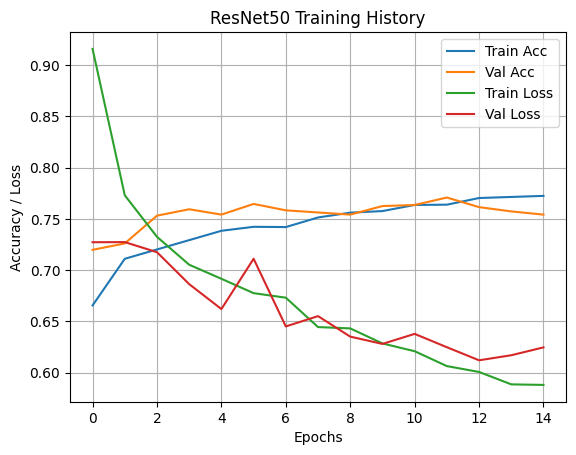

 ResNet50 Training Accuracy: 0.7724
 ResNet50 Validation Accuracy: 0.7542
 Training Time: 433.93 seconds


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

# Build model
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.47)(x)
x = Dense(238, activation='relu')(x)
x = Dropout(0.47)(x)
output = Dense(3, activation='softmax')(x)

resnet50_model = Model(inputs=base.input, outputs=output)
resnet50_model.compile(optimizer=Adam(learning_rate=0.000408), loss='categorical_crossentropy', metrics=['accuracy'])

# Train and track time
start_time = time.time()
history_resnet50 = resnet50_model.fit(train_generator, validation_data=val_generator, epochs=15)
end_time = time.time()

# Save model
resnet50_model.save("/content/drive/MyDrive/Final_ABER_Models/ResNet50_ABER_Optimized.keras")

# Plot
plt.plot(history_resnet50.history['accuracy'], label='Train Acc')
plt.plot(history_resnet50.history['val_accuracy'], label='Val Acc')
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy report
print(f" ResNet50 Training Accuracy: {history_resnet50.history['accuracy'][-1]:.4f}")
print(f" ResNet50 Validation Accuracy: {history_resnet50.history['val_accuracy'][-1]:.4f}")
print(f" Training Time: {end_time - start_time:.2f} seconds")


# mobilenet

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.7631 - loss: 0.6561 - val_accuracy: 0.8417 - val_loss: 0.4039
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.8648 - loss: 0.3423 - val_accuracy: 0.8604 - val_loss: 0.3814
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 190ms/step - accuracy: 0.8640 - loss: 0.3160 - val_accuracy: 0.8573 - val_loss: 0.4194
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.8775 - loss: 0.2787 - val_accuracy: 0.8438 - val_loss: 0.4104
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.8925 - loss: 0.2638 - val_accuracy: 0.8740 - val_loss: 0.4093
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 239ms/step - accuracy: 0.8996 - loss: 0.2537 - val_accuracy: 0.8573 - val_loss: 0.4253
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.8971 - loss: 0.2582 - val_accuracy: 0.8562 - val_loss: 0.4455
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━

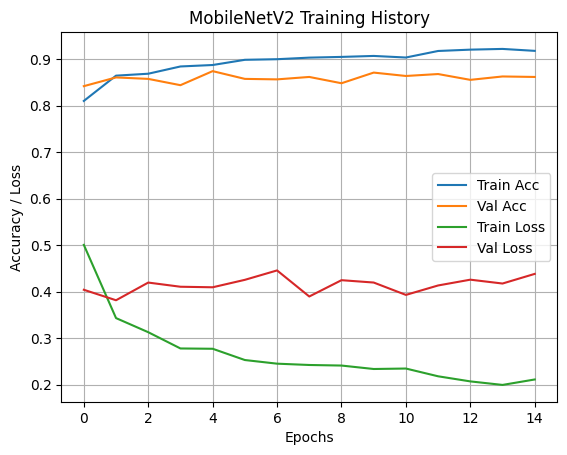

 MobileNetV2 Training Accuracy: 0.9176
 MobileNetV2 Validation Accuracy: 0.8615
 Training Time: 389.64 seconds


In [12]:
from tensorflow.keras.applications import MobileNetV2

# Build model
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.44)(x)
x = Dense(124, activation='relu')(x)
x = Dropout(0.44)(x)
output = Dense(3, activation='softmax')(x)

mobilenet_model = Model(inputs=base.input, outputs=output)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.000640), loss='categorical_crossentropy', metrics=['accuracy'])

# Train and track time
start_time = time.time()
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=val_generator, epochs=15)
end_time = time.time()

# Save model
mobilenet_model.save("/content/drive/MyDrive/Final_ABER_Models/MobileNetV2_ABER_Optimized.keras")

# Plot
plt.plot(history_mobilenet.history['accuracy'], label='Train Acc')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Acc')
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy report
print(f" MobileNetV2 Training Accuracy: {history_mobilenet.history['accuracy'][-1]:.4f}")
print(f" MobileNetV2 Validation Accuracy: {history_mobilenet.history['val_accuracy'][-1]:.4f}")
print(f" Training Time: {end_time - start_time:.2f} seconds")


# efficientnet

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 64s 356ms/step - accuracy: 0.6691 - loss: 0.8703 - val_accuracy: 0.7146 - val_loss: 0.7900
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step - accuracy: 0.7205 - loss: 0.7969 - val_accuracy: 0.7146 - val_loss: 0.7982
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.7268 - loss: 0.7867 - val_accuracy: 0.7146 - val_loss: 0.7989
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.7034 - loss: 0.8212 - val_accuracy: 0.7146 - val_loss: 0.7909
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.7192 - loss: 0.7963 - val_accuracy: 0.7146 - val_loss: 0.7934
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.7078 - loss: 0.8128 - val_accuracy: 0.7146 - val_loss: 0.7891
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.7173 - loss: 0.7921 - val_accuracy: 0.7146 - val_loss: 0.7897
Epoch 8/15
121/121 ━━━━━━━━━━━━━

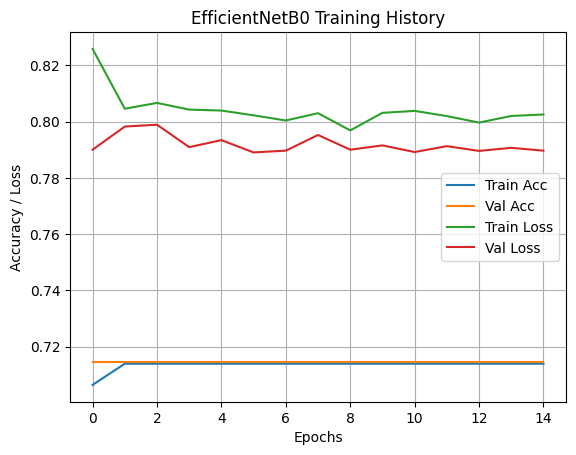

 EfficientNetB0 Training Accuracy: 0.7139
 EfficientNetB0 Validation Accuracy: 0.7146
 Training Time: 465.86 seconds


In [13]:
from tensorflow.keras.applications import EfficientNetB0

# Build model
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.38)(x)
x = Dense(181, activation='relu')(x)
x = Dropout(0.38)(x)
output = Dense(3, activation='softmax')(x)

efficientnet_model = Model(inputs=base.input, outputs=output)
efficientnet_model.compile(optimizer=Adam(learning_rate=0.000159), loss='categorical_crossentropy', metrics=['accuracy'])

# Train and track time
start_time = time.time()
history_efficientnet = efficientnet_model.fit(train_generator, validation_data=val_generator, epochs=15)
end_time = time.time()

# Save model
efficientnet_model.save("/content/drive/MyDrive/Final_ABER_Models/EfficientNetB0_ABER_Optimized.keras")

# Plot
plt.plot(history_efficientnet.history['accuracy'], label='Train Acc')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Acc')
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy report
print(f" EfficientNetB0 Training Accuracy: {history_efficientnet.history['accuracy'][-1]:.4f}")
print(f" EfficientNetB0 Validation Accuracy: {history_efficientnet.history['val_accuracy'][-1]:.4f}")
print(f" Training Time: {end_time - start_time:.2f} seconds")


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load class names from your val_generator
class_names = list(val_generator.class_indices.keys())

def evaluate_aber_model(model_path, model_name):
    model = load_model(model_path)

    # Predict
    val_generator.reset()
    y_probs = model.predict(val_generator)
    y_preds = np.argmax(y_probs, axis=1)
    y_true = val_generator.classes

    # Accuracy
    acc = np.mean(y_preds == y_true)
    print(f"\n {model_name} Accuracy: {acc:.4f}")

    # Classification report
    print(f"\n Classification Report for {model_name}:")
    print(classification_report(y_true, y_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC AUC (multi-class)
    try:
        auc = roc_auc_score(val_generator.labels, y_probs, multi_class='ovr')
        print(f" ROC AUC Score: {auc:.4f}")
    except Exception as e:
        print(" ROC AUC could not be computed:", e)

    return acc


 Evaluating: VGG16_ABER


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step

 VGG16_ABER Accuracy: 0.8365

 Classification Report for VGG16_ABER:
              precision    recall  f1-score   support

      benign       0.84      0.96      0.89       686
   malignant       0.79      0.54      0.64       168
      normal       0.93      0.51      0.66       106

    accuracy                           0.84       960
   macro avg       0.85      0.67      0.73       960
weighted avg       0.84      0.84      0.82       960



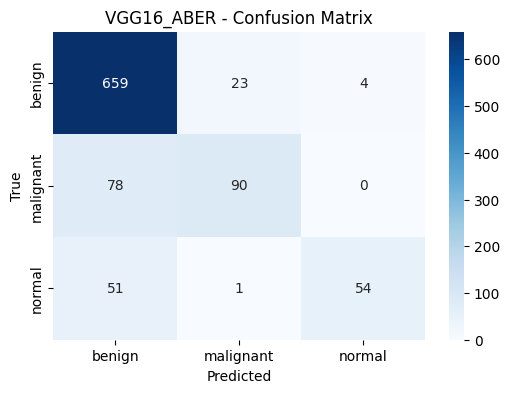

 ROC AUC Score: 0.9006
 Evaluating: ResNet50_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step

 ResNet50_ABER Accuracy: 0.7542

 Classification Report for ResNet50_ABER:
              precision    recall  f1-score   support

      benign       0.74      1.00      0.85       686
   malignant       0.97      0.23      0.38       168
      normal       0.00      0.00      0.00       106

    accuracy                           0.75       960
   macro avg       0.57      0.41      0.41       960
weighted avg       0.70      0.75      0.68       960



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


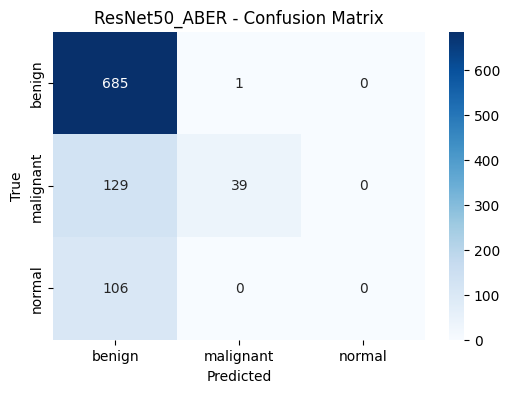

 ROC AUC Score: 0.7819
 Evaluating: MobileNetV2_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step

 MobileNetV2_ABER Accuracy: 0.8615

 Classification Report for MobileNetV2_ABER:
              precision    recall  f1-score   support

      benign       0.87      0.96      0.91       686
   malignant       0.79      0.58      0.67       168
      normal       0.93      0.65      0.77       106

    accuracy                           0.86       960
   macro avg       0.86      0.73      0.78       960
weighted avg       0.86      0.86      0.85       960



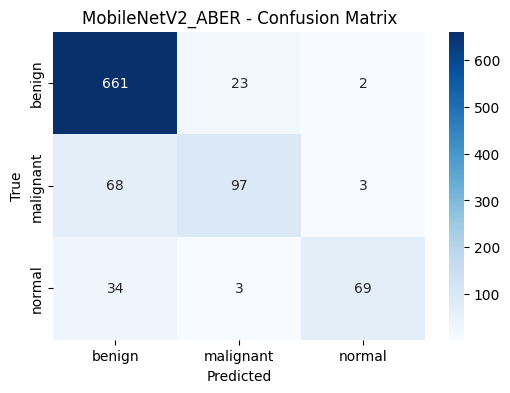

 ROC AUC Score: 0.9306
 Evaluating: EfficientNetB0_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step

 EfficientNetB0_ABER Accuracy: 0.7146

 Classification Report for EfficientNetB0_ABER:
              precision    recall  f1-score   support

      benign       0.71      1.00      0.83       686
   malignant       0.00      0.00      0.00       168
      normal       0.00      0.00      0.00       106

    accuracy                           0.71       960
   macro avg       0.24      0.33      0.28       960
weighted avg       0.51      0.71      0.60       960



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


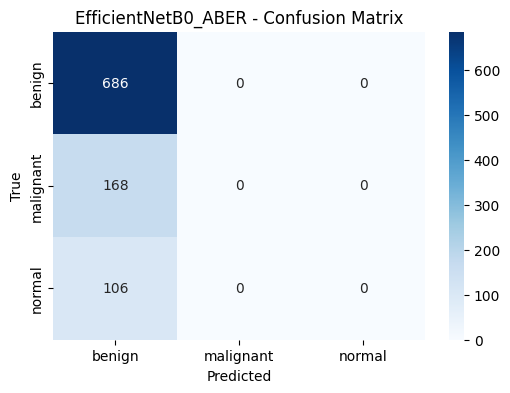

 ROC AUC Score: 0.5598


In [10]:
model_paths = {
    "VGG16_ABER": "/content/drive/MyDrive/Final_ABER_Models/VGG16_ABER_Optimized.keras",
    "ResNet50_ABER": "/content/drive/MyDrive/Final_ABER_Models/ResNet50_ABER_Optimized.keras",
    "MobileNetV2_ABER": "/content/drive/MyDrive/Final_ABER_Models/MobileNetV2_ABER_Optimized.keras",
    "EfficientNetB0_ABER": "/content/drive/MyDrive/Final_ABER_Models/EfficientNetB0_ABER_Optimized.keras"
}

aber_model_accuracies = {}

for name, path in model_paths.items():
    print(f" Evaluating: {name}")
    acc = evaluate_aber_model(path, name)
    aber_model_accuracies[name] = acc


 Evaluating: VGG16_ABER
 VGG16_ABER Accuracy: 0.8365
 Evaluating: ResNet50_ABER
 ResNet50_ABER Accuracy: 0.7542
 Evaluating: MobileNetV2_ABER
 MobileNetV2_ABER Accuracy: 0.8615
 Evaluating: EfficientNetB0_ABER
 EfficientNetB0_ABER Accuracy: 0.7146


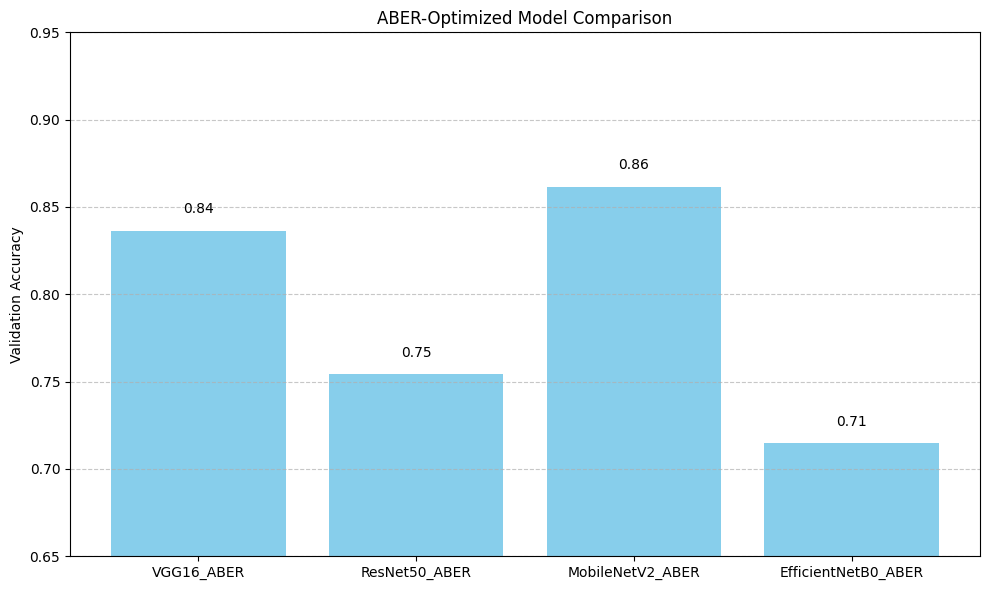

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

#  Step 1: Define model names and paths
model_info = {
    "VGG16_ABER": "/content/drive/MyDrive/Final_ABER_Models/VGG16_ABER_Optimized.keras",
    "ResNet50_ABER": "/content/drive/MyDrive/Final_ABER_Models/ResNet50_ABER_Optimized.keras",
    "MobileNetV2_ABER": "/content/drive/MyDrive/Final_ABER_Models/MobileNetV2_ABER_Optimized.keras",
    "EfficientNetB0_ABER": "/content/drive/MyDrive/Final_ABER_Models/EfficientNetB0_ABER_Optimized.keras"
}

# Step 2: Evaluate models on validation data
model_names = []
accuracies = []

for name, path in model_info.items():
    print(f" Evaluating: {name}")
    model = load_model(path)
    loss, acc = model.evaluate(val_generator, verbose=0)
    print(f" {name} Accuracy: {acc:.4f}")
    model_names.append(name)
    accuracies.append(acc)

#  Step 3: Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=10)

plt.title("ABER-Optimized Model Comparison")
plt.ylabel("Validation Accuracy")
plt.ylim(0.65, 0.95)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 Evaluating: VGG16_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
 VGG16_ABER → Accuracy: 0.8365, ROC-AUC: 0.9006
 Evaluating: ResNet50_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step
 ResNet50_ABER → Accuracy: 0.7542, ROC-AUC: 0.7819
 Evaluating: MobileNetV2_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step
 MobileNetV2_ABER → Accuracy: 0.8615, ROC-AUC: 0.9306
 Evaluating: EfficientNetB0_ABER
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step
 EfficientNetB0_ABER → Accuracy: 0.7146, ROC-AUC: 0.5598


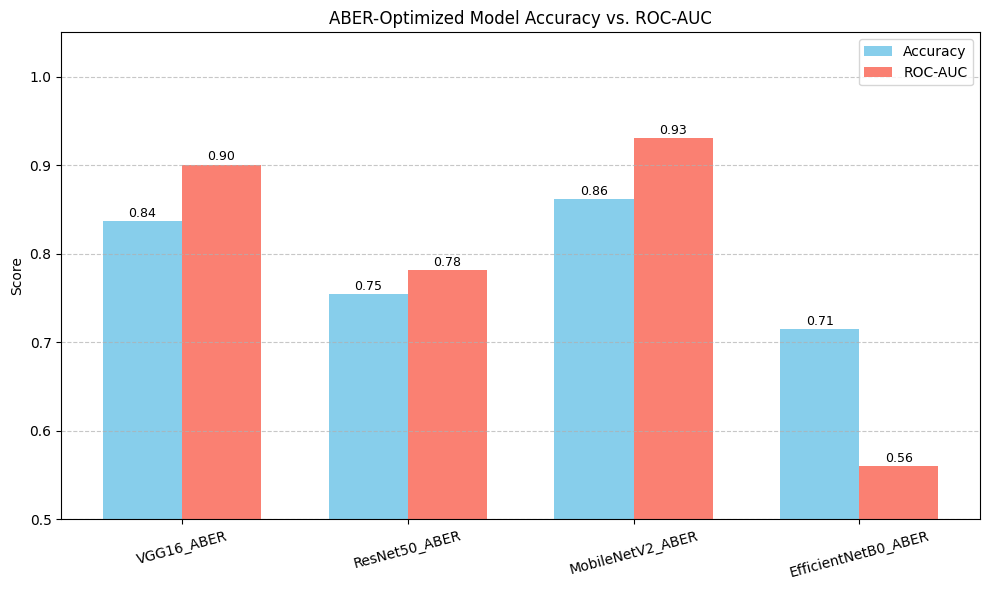

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

# Define model paths
model_info = {
    "VGG16_ABER": "/content/drive/MyDrive/Final_ABER_Models/VGG16_ABER_Optimized.keras",
    "ResNet50_ABER": "/content/drive/MyDrive/Final_ABER_Models/ResNet50_ABER_Optimized.keras",
    "MobileNetV2_ABER": "/content/drive/MyDrive/Final_ABER_Models/MobileNetV2_ABER_Optimized.keras",
    "EfficientNetB0_ABER": "/content/drive/MyDrive/Final_ABER_Models/EfficientNetB0_ABER_Optimized.keras"
}

# Setup to store results
model_names = []
accuracies = []
roc_aucs = []

# True labels
val_generator.reset()
y_true = val_generator.classes
y_true_cat = to_categorical(y_true, num_classes=3)

#  Loop through each model and compute metrics
for name, path in model_info.items():
    print(f" Evaluating: {name}")
    model = load_model(path)

    # Accuracy
    loss, acc = model.evaluate(val_generator, verbose=0)
    accuracies.append(acc)

    # ROC-AUC
    val_generator.reset()
    y_probs = model.predict(val_generator)
    roc_auc = roc_auc_score(y_true_cat, y_probs, multi_class='ovr')
    roc_aucs.append(roc_auc)

    model_names.append(name)
    print(f" {name} → Accuracy: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")

#  Plot Accuracy vs. ROC-AUC
x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
bar2 = plt.bar(x + width/2, roc_aucs, width, label='ROC-AUC', color='salmon')

# Annotate bars
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.xticks(x, model_names, rotation=15)
plt.ylim(0.5, 1.05)
plt.ylabel("Score")
plt.title("ABER-Optimized Model Accuracy vs. ROC-AUC")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 Evaluating loss for: VGG16_ABER
 VGG16_ABER → Validation Loss: 0.4302
 Evaluating loss for: ResNet50_ABER
 ResNet50_ABER → Validation Loss: 0.6246
 Evaluating loss for: MobileNetV2_ABER
 MobileNetV2_ABER → Validation Loss: 0.4381
 Evaluating loss for: EfficientNetB0_ABER
 EfficientNetB0_ABER → Validation Loss: 0.7897


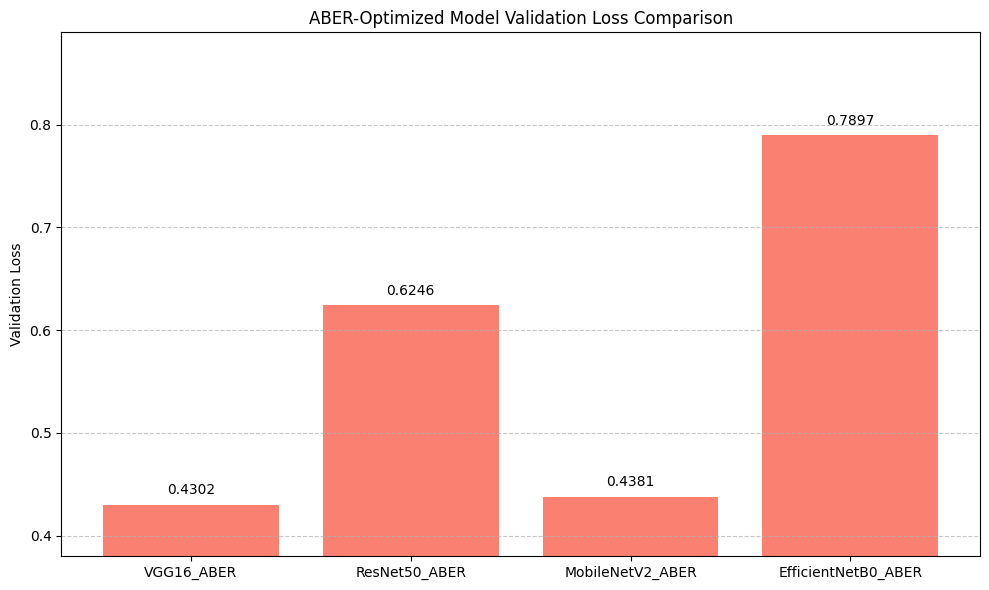

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#  Define model paths
model_info = {
    "VGG16_ABER": "/content/drive/MyDrive/Final_ABER_Models/VGG16_ABER_Optimized.keras",
    "ResNet50_ABER": "/content/drive/MyDrive/Final_ABER_Models/ResNet50_ABER_Optimized.keras",
    "MobileNetV2_ABER": "/content/drive/MyDrive/Final_ABER_Models/MobileNetV2_ABER_Optimized.keras",
    "EfficientNetB0_ABER": "/content/drive/MyDrive/Final_ABER_Models/EfficientNetB0_ABER_Optimized.keras"
}

#  Lists to store results
model_names = []
val_losses = []

#  Loop to evaluate losses
for name, path in model_info.items():
    print(f" Evaluating loss for: {name}")
    model = load_model(path)
    loss, acc = model.evaluate(val_generator, verbose=0)
    model_names.append(name)
    val_losses.append(loss)
    print(f" {name} → Validation Loss: {loss:.4f}")

#  Plotting the loss comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, val_losses, color='salmon')

# Add loss values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.4f}", ha='center', fontsize=10)

plt.title("ABER-Optimized Model Validation Loss Comparison")
plt.ylabel("Validation Loss")
plt.ylim(min(val_losses) - 0.05, max(val_losses) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# Predictions

In [14]:
from tensorflow.keras.models import load_model

vgg16_model = load_model("/content/drive/MyDrive/Final_ABER_Models/VGG16_ABER_Optimized.keras")
resnet50_model = load_model("/content/drive/MyDrive/Final_ABER_Models/ResNet50_ABER_Optimized.keras")
mobilenet_model = load_model("/content/drive/MyDrive/Final_ABER_Models/MobileNetV2_ABER_Optimized.keras")
efficientnet_model = load_model("/content/drive/MyDrive/Final_ABER_Models/EfficientNetB0_ABER_Optimized.keras")


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image


img_path = "/content/drive/MyDrive/BUSI_augmented/benign/benign (1)_aug4.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0


In [19]:

class_names = ['benign', 'malignant', 'normal']

# Predict from each model
pred_vgg16 = vgg16_model.predict(img_array)
pred_resnet = resnet50_model.predict(img_array)
pred_mobilenet = mobilenet_model.predict(img_array)
pred_efficientnet = efficientnet_model.predict(img_array)

# Decode predictions
print(" Prediction Results:\n")

print(" VGG16 Prediction:", class_names[np.argmax(pred_vgg16)], "→ Prob:", np.max(pred_vgg16).round(4))
print(" ResNet50 Prediction:", class_names[np.argmax(pred_resnet)], "→ Prob:", np.max(pred_resnet).round(4))
print(" MobileNetV2 Prediction:", class_names[np.argmax(pred_mobilenet)], "→ Prob:", np.max(pred_mobilenet).round(4))
print(" EfficientNetB0 Prediction:", class_names[np.argmax(pred_efficientnet)], "→ Prob:", np.max(pred_efficientnet).round(4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
 Prediction Results:

 VGG16 Prediction: benign → Prob: 0.9788
 ResNet50 Prediction: benign → Prob: 0.7957
 MobileNetV2 Prediction: benign → Prob: 0.9981
 EfficientNetB0 Prediction: benign → Prob: 0.6926


In [22]:
img_path = "/content/drive/MyDrive/BUSI_augmented/normal/normal (100)_mask_aug0.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [23]:

class_names = ['benign', 'malignant', 'normal']

# Predict from each model
pred_vgg16 = vgg16_model.predict(img_array)
pred_resnet = resnet50_model.predict(img_array)
pred_mobilenet = mobilenet_model.predict(img_array)
pred_efficientnet = efficientnet_model.predict(img_array)

# Decode predictions
print(" Prediction Results:\n")

print(" VGG16 Prediction:", class_names[np.argmax(pred_vgg16)], "→ Prob:", np.max(pred_vgg16).round(4))
print(" ResNet50 Prediction:", class_names[np.argmax(pred_resnet)], "→ Prob:", np.max(pred_resnet).round(4))
print(" MobileNetV2 Prediction:", class_names[np.argmax(pred_mobilenet)], "→ Prob:", np.max(pred_mobilenet).round(4))
print(" EfficientNetB0 Prediction:", class_names[np.argmax(pred_efficientnet)], "→ Prob:", np.max(pred_efficientnet).round(4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
 Prediction Results:

 VGG16 Prediction: normal → Prob: 0.9119
 ResNet50 Prediction: benign → Prob: 0.4473
 MobileNetV2 Prediction: normal → Prob: 0.9999
 EfficientNetB0 Prediction: benign → Prob: 0.6928


In [24]:
img_path = "/content/drive/MyDrive/BUSI_augmented/malignant/malignant (103)_mask_aug1.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [25]:

class_names = ['benign', 'malignant', 'normal']

# Predict from each model
pred_vgg16 = vgg16_model.predict(img_array)
pred_resnet = resnet50_model.predict(img_array)
pred_mobilenet = mobilenet_model.predict(img_array)
pred_efficientnet = efficientnet_model.predict(img_array)

# Decode predictions
print(" Prediction Results:\n")

print(" VGG16 Prediction:", class_names[np.argmax(pred_vgg16)], "→ Prob:", np.max(pred_vgg16).round(4))
print(" ResNet50 Prediction:", class_names[np.argmax(pred_resnet)], "→ Prob:", np.max(pred_resnet).round(4))
print(" MobileNetV2 Prediction:", class_names[np.argmax(pred_mobilenet)], "→ Prob:", np.max(pred_mobilenet).round(4))
print(" EfficientNetB0 Prediction:", class_names[np.argmax(pred_efficientnet)], "→ Prob:", np.max(pred_efficientnet).round(4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 Prediction Results:

 VGG16 Prediction: malignant → Prob: 0.9998
 ResNet50 Prediction: malignant → Prob: 0.926
 MobileNetV2 Prediction: malignant → Prob: 1.0
 EfficientNetB0 Prediction: benign → Prob: 0.6934
